In [7]:
import os, sys
sys.path.append(os.getcwd())
sys.path.append(os.getcwd()+"/FlexModEHC/")

import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

from generators import Generator
from propagators import Propagator

import complextools 

In [8]:
tau = 2
alpha = .65
A = np.array([[-1,1,0],[0,-1,1],[1, 0,-1]]) #lambda = [0, -(3+i*np.sqrt(3))/2, -(3-i*np.sqrt(3))/2]
# A = np.array([[-1,1,0],[0,-1,1],[0, 1,-1]])
B = np.array([[-2,1,1],[1,-2,1],[1,1,-2]])/3  #lambda = [0,-1,-1]

n_state = 90
# A = circle_diffusion(n_state, [1, 1], symmetric=True)
A = complextools.circle_diffusion(n_state)
gen_O = A
n_state = gen_O.shape[0]
np.linalg.det(A)

0.0

In [9]:
#show generator as a matrix
# plt.matshow(gen_O)
# plt.colorbar()

In [10]:
#show generator as a graph
DG = nx.from_numpy_array(A, create_using=nx.DiGraph)
pos = nx.spectral_layout(DG)
# nx.draw(DG, pos=pos, with_labels=True, font_weight='bold')

In [11]:
eigenvalues, G, W = complextools.eigendecompose(gen_O)
s = np.exp(eigenvalues**alpha/tau)
n_state = gen_O.shape[0]
# rho = np.ones((n_state,))/n_state
rho =  np.zeros((n_state,))
rho[0] = 1.
Gamma = complextools.calcul_Gamma(G, W)

T_steps = 20
deltaT = np.linspace(0,T_steps,T_steps+1)

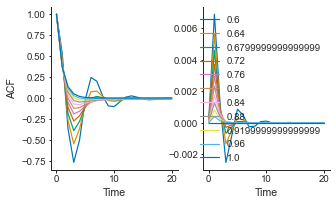

In [12]:
# %matplotlib
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
tau=1
alphas = np.linspace(.6,1,11)
# alphas = np.linspace(.9,1,11)
for alpha in alphas:
    s = np.exp(eigenvalues**alpha/tau)
    auto_corr = complextools.zcf_gen(s, Gamma, deltaT, rho)
    # extract real part
    x = [ele.real for ele in auto_corr]
    # extract imaginary part
    y = [ele.imag for ele in auto_corr]
    axes[0].plot(x)
    axes[1].plot(y, label=str(alpha))
    axes[1].legend(loc='best')
#     plt.plot(auto_corr)
axes[0].set_ylabel("ACF")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")

plt.show()

In [13]:
# start_prop = ENV.start_center #rho_0

jump_rate = 1.
symmetrize = False
forward = True
GEN = Generator(Q=gen_O, forward=forward, symmetrize=symmetrize, jump_rate=jump_rate);
PROP = Propagator(GEN=GEN);

GENERATOR: explicit generator provided
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is not symmetric.
GENERATOR: Q is a generator with shape (90, 90) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 1
EIGENSPECTRUM: complex eigenvalues: [-0.00243595+0.06975647j -0.00243595-0.06975647j -0.00973193-0.1391731j
 -0.00973193+0.1391731j  -0.0218524 -0.20791169j -0.0218524 +0.20791169j
 -0.0387383 -0.27563736j -0.0387383 +0.27563736j -0.06030738-0.34202014j
 -0.06030738+0.34202014j -0.08645454-0.40673664j -0.08645454+0.40673664j
 -0.11705241-0.46947156j -0.11705241+0.46947156j -0.1519519 -0.52991926j
 -0.1519519 +0.52991926j -0.19098301-0.58778525j -0.19098301+0.58778525j
 -0.23395556-0.64278761j -0.23395556+0.64278761j -0.2806602 -0.69465837j
 -0.2806602 +0.69465837j -0.33086939-0.74314483j -0.33086939+0.74314483j
 -0.38433852-0.78801075j -0.38433852+0.78801075j -0.4408071 -0.82903757j
 -0.4408071 +0.82903757j -0.5       +0.8660254j  -0.5       -0.8660254j
 -0.56162885-0

In [14]:
# etO is squashed baecause of PROP.wetD?
spec_basis = np.matmul(PROP.GEN.EVEC_fwd, PROP.wetD)
Uinv = PROP.GEN.EVEC_fwd
etO = np.matmul(spec_basis, Uinv)

#calculate etO(=exp(gen_O)) without absolute values, i.e. leave complex values as they are
power_spec = PROP.spectral_density(t=1.0)
sigma = 1
t = 1
alpha = .95 #diverges for alpha<=0.97
sigma_alpha = sigma ** (2 * alpha)
L = PROP.GEN.evals_fwd
L = complextools.rotate(L, np.pi/100)
L_alpha = L ** (alpha)
x = sigma_alpha * L_alpha * t / tau
d = np.exp(x)

etD = (np.eye(n_state) * d)  # d = power_spec, etD=spectral power as a diagonal matrix
spec_comp_weights = np.ones((n_state,))
wetD = spec_comp_weights * etD
spec_basis = np.matmul(PROP.GEN.EVEC_fwd, wetD)
Uinv = PROP.GEN.EVECinv_fwd
etO = np.matmul(spec_basis, Uinv)

In [15]:
#difference between complex and real etO
# etO.sum(0)-PROP.etO.sum(0)

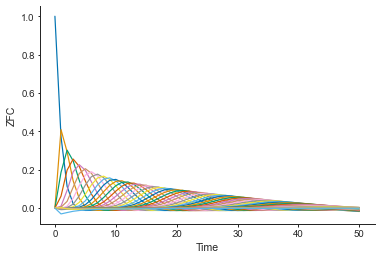

In [19]:
#Generate samples/Simulate and plot
rho_t = rho
rhos = [rho]
for i in range(50):
    rho_t = np.dot(rho_t, etO)
    rhos.append(rho_t)
    
plt.plot(rhos)
plt.xlabel("Time")
plt.ylabel("ZFC");